<a href="https://colab.research.google.com/github/mohamed-zayton/Face-Recognition/blob/non_face/pca_lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import PIL
from PIL import Image
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import glob


1. Download the Dataset and Understand the Format

In [2]:
#Downloaded in the project directory
#Image formate pgm 'grey scale img'

# 2. Generate the Data Matrix and the Label vector

In [3]:
i = 0
s = 1
x = 1
d = [0] * 400
y = [0] * 400

In [4]:
while i < 400:
  image = PIL.Image.open("dataset/s" + str(s) + "/" + str(x) + ".pgm")
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  d[i] = image_array
  y[i] = s
  i = i + 1
  x = x + 1
  if x == 11:
    s = s + 1
    x = 1

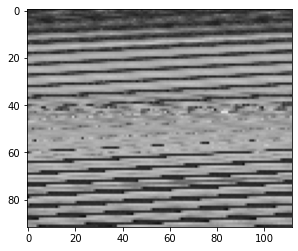

In [5]:
plt.imshow(np.reshape(d[0], (92, 112)), cmap='gray', vmin=0, vmax=255)
plt.show()

# 3. Split the Dataset into Training and Test sets

In [6]:
training_data = [0] * 200
testing_data = [0] * 200
training_labels = [0] * 200
testing_labels = [0] * 200
curr_index = 0

In [7]:
for i in range(1, 400, 2):
  curr_index = int(i / 2)
  testing_data[curr_index] = d[i]
  testing_labels[curr_index] = y[i]
  training_data[curr_index] = d[i - 1]
  training_labels[curr_index] = y[i - 1]

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)
training_data = np.array(training_data)
training_labels = np.array(training_labels)

In [8]:
testing_data.shape

(200, 10304)

# 4. Classification using PCA

#### Declaring variables

In [9]:
alpha = [0.8, 0.85, 0.9, 0.95]
n = len(testing_data[0])

#### Calculating centered data, covariance matrix, eigen values, and eigen vectors

In [10]:
def calculate_reduced_basis(data_to_reduce, alpha_val):
    
    attributes_means = np.mean(data_to_reduce, axis=0)
    Z = np.subtract(data_to_reduce, attributes_means.T)
    cov_matrix = np.cov(Z.T)
    eval, evec = np.linalg.eigh(cov_matrix)
    
    idx = eval.argsort()[::-1]
    eva = eval[idx]
    eve = evec[:,idx]
    eval_sum = np.sum(eval)
    
    reduced_basis = []
    for curr_alpha in alpha:
        dimensionality = 0
        curr_eval_sum = 0
        for curr_eval in eva:
            dimensionality += 1
            curr_eval_sum += curr_eval
            if curr_eval_sum / eval_sum >= curr_alpha:
                break
    
        reduced_basis.append(eve[:, :dimensionality])
        
    return reduced_basis

### 6. Classifier Tuning

#### Declaring the models

In [11]:
model_1_pca = KNeighborsClassifier(n_neighbors=1)
model_3_pca = KNeighborsClassifier(n_neighbors=3)
model_5_pca = KNeighborsClassifier(n_neighbors=5)
model_7_pca = KNeighborsClassifier(n_neighbors=7)
models = [model_1_pca, model_3_pca, model_5_pca, model_7_pca]

#### Classifying the images

In [12]:
def classify_images(f_alpha, f_training_reduced_basis, f_training_data, f_training_labels, f_testing_data, f_testing_labels):
    for i in range(len(f_alpha)):
        reduced_dim_data = np.dot(f_training_data, f_training_reduced_basis[i])
        reduced_dim_test = np.dot(f_testing_data, f_training_reduced_basis[i])
        
        model_1_pca.fit(reduced_dim_data, f_training_labels)
        model_3_pca.fit(reduced_dim_data, f_training_labels)
        model_5_pca.fit(reduced_dim_data, f_training_labels)
        model_7_pca.fit(reduced_dim_data, f_training_labels)
        
        print("When alpha = " + str(f_alpha[i]))
        for k in range(1, 8, 2):
            pred_model = models[int(k / 2)].predict(reduced_dim_test)
            print("K-NN classifier PCA " + str(k) + "  Accuracy is: " + str(accuracy_score(f_testing_labels, pred_model)))
        
        print("**********************")

In [13]:
training_reduced_basis = calculate_reduced_basis(training_data, alpha)

In [14]:
classify_images(alpha, training_reduced_basis, training_data, training_labels, testing_data, testing_labels)

When alpha = 0.8
K-NN classifier PCA 1  Accuracy is: 0.95
K-NN classifier PCA 3  Accuracy is: 0.89
K-NN classifier PCA 5  Accuracy is: 0.845
K-NN classifier PCA 7  Accuracy is: 0.8
**********************
When alpha = 0.85
K-NN classifier PCA 1  Accuracy is: 0.95
K-NN classifier PCA 3  Accuracy is: 0.89
K-NN classifier PCA 5  Accuracy is: 0.84
K-NN classifier PCA 7  Accuracy is: 0.77
**********************
When alpha = 0.9
K-NN classifier PCA 1  Accuracy is: 0.94
K-NN classifier PCA 3  Accuracy is: 0.885
K-NN classifier PCA 5  Accuracy is: 0.835
K-NN classifier PCA 7  Accuracy is: 0.775
**********************
When alpha = 0.95
K-NN classifier PCA 1  Accuracy is: 0.94
K-NN classifier PCA 3  Accuracy is: 0.895
K-NN classifier PCA 5  Accuracy is: 0.845
K-NN classifier PCA 7  Accuracy is: 0.74
**********************


# 5. Classification Using LDA

In [15]:
def center_function(d):
    m = np.mean(d, axis=0)
    return np.subtract(d, m)

In [16]:
def lda(data, l, dom, n_class, features):
  # Calculate the mean of feature for every class
  # Mean matrix is 10304x1 dim
  cdata = []
  mean_c = []
  if n_class != 2:
    for i in range(0, len(data), l):
      cdata.append(data[i:i+l])
    for i in range(n_class):
      mean_c.append(np.mean(cdata[i], axis=0))
    if n_class != 2:
      tmean = np.mean(data, axis=0) 
  else:
    for part in l:
      for i in range(0, len(data), part):
        cdata.append(data[i:i+part])
      for i in range(n_class):
        mean_c.append(np.mean(cdata[i], axis=0))
      if n_class != 2:
        tmean = np.mean(data, axis=0)

  # Calculate between-class scatter matrix
  # B matrix is 10304 x 10304
  bmat = np.zeros((features, features))
  if n_class == 2:
    sub = np.subtract(mean_c[0], mean_c[1])
    bmat = np.dot(sub, sub.T)
  else:
    tm = tmean[:, np.newaxis]
    for i in range(n_class):
      mc = mean_c[i][:, np.newaxis]
      sub = np.subtract(mc, tm)
      bmat += np.multiply(l, np.dot(sub, sub.T))

  # Center class matrix 
  # Zi matrix is 5 x 10304
  zmat = []
  for d in cdata:
    zmat.append(center_function(d))
  
  # Class scatter matrix 
  # S matrix is 10304 x 10304
  s_tot = np.zeros((features, features))
  for zi in zmat:
    s_tot += np.dot(zi.T, zi)
 
  # Compute dominant eigenvector
  eval, evec = np.linalg.eigh(np.dot(np.linalg.inv(s_tot), bmat))

  # Return the 39 dominant eigenvectors and the mean
  idx = eval.argsort()[::-1]
  eva = eval[idx]
  eve = evec[:,idx]
  dom_arr = eve[:,:dom]
  
  return dom_arr.T

In [17]:
pj_mat = lda(training_data, 5, 39, 40, 10304)

In [18]:
pj_mat.shape

(39, 10304)

In [19]:
np.asarray(d).shape

(400, 10304)

In [20]:
new_train = np.dot(training_data, pj_mat.T)
new_train.shape

(200, 39)

In [21]:
new_test = np.dot(testing_data, pj_mat.T)
new_test.shape

(200, 39)

### 6. Classifier Tuning

In [22]:
model_1_lda = KNeighborsClassifier(n_neighbors=1)
model_3_lda = KNeighborsClassifier(n_neighbors=3)
model_5_lda = KNeighborsClassifier(n_neighbors=5)
model_7_lda = KNeighborsClassifier(n_neighbors=7)

In [23]:
model_1_lda.fit(new_train, training_labels)
model_3_lda.fit(new_train, training_labels)
model_5_lda.fit(new_train, training_labels)
model_7_lda.fit(new_train, training_labels)

KNeighborsClassifier(n_neighbors=7)

In [24]:
pred_model_1_lda = model_1_lda.predict(new_test)
pred_model_3_lda = model_3_lda.predict(new_test)
pred_model_5_lda = model_5_lda.predict(new_test)
pred_model_7_lda = model_7_lda.predict(new_test)
pred_model_1_lda

array([ 1,  1,  1,  1, 18,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
       25,  4,  4,  5,  5,  5,  5, 40,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10,  8, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14,
       14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 29, 20, 20, 21, 21,
       21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24,
       24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28,
       28, 28, 37, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31,
       31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34,
       25, 15, 35, 25, 40, 36, 36, 36, 36, 17, 37, 37, 37, 37, 37, 38, 38,
       38, 38, 38, 39, 39, 39, 39, 39, 40,  5, 40, 40,  5])

In [25]:
testing_labels

array([ 1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14,
       14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21,
       21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24,
       24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28,
       28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31,
       31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34,
       35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38,
       38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40])

In [26]:
acc_1_lda = accuracy_score(testing_labels, pred_model_1_lda)
acc_3_lda = accuracy_score(testing_labels, pred_model_3_lda)
acc_5_lda = accuracy_score(testing_labels, pred_model_5_lda)
acc_7_lda = accuracy_score(testing_labels, pred_model_7_lda)
print(acc_1_lda)
print(acc_3_lda)
print(acc_5_lda)
print(acc_7_lda)

0.935
0.885
0.82
0.795


### Compare PCA & LDA

In [27]:
print("K-NN classifier 1 LDA   Accuracy is: " + str(acc_1_lda))
print("K-NN classifier 3 LDA   Accuracy is: " + str(acc_3_lda))
print("K-NN classifier 5 LDA   Accuracy is: " + str(acc_5_lda))
print("K-NN classifier 7 LDA   Accuracy is: " + str(acc_7_lda))
for i in range(len(alpha)):
    reduced_dim_data = np.dot(training_data, training_reduced_basis[i])
    reduced_dim_test = np.dot(testing_data, training_reduced_basis[i])
    
    model_1_pca.fit(reduced_dim_data, training_labels)
    model_3_pca.fit(reduced_dim_data, training_labels)
    model_5_pca.fit(reduced_dim_data, training_labels)
    model_7_pca.fit(reduced_dim_data, training_labels)
    
    print("When alpha = " + str(alpha[i]))
    for k in range(1, 8, 2):
        pred_model = models[int(k / 2)].predict(reduced_dim_test)
        print("K-NN classifier PCA " + str(k) + "  Accuracy is: " + str(accuracy_score(testing_labels, pred_model)))
        
    print("**********************")

K-NN classifier 1 LDA   Accuracy is: 0.935
K-NN classifier 3 LDA   Accuracy is: 0.885
K-NN classifier 5 LDA   Accuracy is: 0.82
K-NN classifier 7 LDA   Accuracy is: 0.795
When alpha = 0.8
K-NN classifier PCA 1  Accuracy is: 0.95
K-NN classifier PCA 3  Accuracy is: 0.89
K-NN classifier PCA 5  Accuracy is: 0.845
K-NN classifier PCA 7  Accuracy is: 0.8
**********************
When alpha = 0.85
K-NN classifier PCA 1  Accuracy is: 0.95
K-NN classifier PCA 3  Accuracy is: 0.89
K-NN classifier PCA 5  Accuracy is: 0.84
K-NN classifier PCA 7  Accuracy is: 0.77
**********************
When alpha = 0.9
K-NN classifier PCA 1  Accuracy is: 0.94
K-NN classifier PCA 3  Accuracy is: 0.885
K-NN classifier PCA 5  Accuracy is: 0.835
K-NN classifier PCA 7  Accuracy is: 0.775
**********************
When alpha = 0.95
K-NN classifier PCA 1  Accuracy is: 0.94
K-NN classifier PCA 3  Accuracy is: 0.895
K-NN classifier PCA 5  Accuracy is: 0.845
K-NN classifier PCA 7  Accuracy is: 0.74
**********************


# 7. Compare vs Non-Face Images

In [28]:
i = 0
x = 1
s = 1
d = [0] * 800
y = [0] * 800

#### Try 400 non-faces img

In [29]:
i = 0
x = 1
s = 1
d = [0] * 800
y = [0] * 800

while i < 400:
  image = PIL.Image.open("dataset/s" + str(s) + "/" + str(x) + ".pgm")
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  d[i] = image_array
  i = i + 1
  x = x + 1
  if x == 11:
    s = s + 1
    x = 1
print(np.array(d).shape)

for filename in glob.glob('dataset/aa/*.jpg'):
  if i >= 800:
    break
  image = PIL.Image.open(filename)
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  image_array.resize((10304,))
  d[i] = image_array
  y[i] = 1
  i = i + 1
  x = x + 1
training_data = [0] * 400
testing_data = [0] * 400
training_labels = [0] * 400
testing_labels = [0] * 400
curr_index = 0

for i in range(1, 800, 2):
  curr_index = int(i / 2)
  testing_data[curr_index] = d[i]
  testing_labels[curr_index] = y[i]
  training_data[curr_index] = d[i - 1]
  training_labels[curr_index] = y[i - 1]

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)
training_data = np.array(training_data)
training_labels = np.array(training_labels)

C:\Users\MOHAME~1\AppData\Local\Temp/ipykernel_19096/97936835.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(d).shape)


(800,)


In [30]:
training_data.shape

(400, 10304)

In [31]:
training_reduced_basis = calculate_reduced_basis(training_data, alpha)

In [32]:
classify_images(alpha, training_reduced_basis, training_data, training_labels, testing_data, testing_labels)

When alpha = 0.8
K-NN classifier PCA 1  Accuracy is: 0.9975
K-NN classifier PCA 3  Accuracy is: 0.99
K-NN classifier PCA 5  Accuracy is: 0.9825
K-NN classifier PCA 7  Accuracy is: 0.9775
**********************
When alpha = 0.85
K-NN classifier PCA 1  Accuracy is: 0.995
K-NN classifier PCA 3  Accuracy is: 0.99
K-NN classifier PCA 5  Accuracy is: 0.98
K-NN classifier PCA 7  Accuracy is: 0.98
**********************
When alpha = 0.9
K-NN classifier PCA 1  Accuracy is: 0.9975
K-NN classifier PCA 3  Accuracy is: 0.99
K-NN classifier PCA 5  Accuracy is: 0.9825
K-NN classifier PCA 7  Accuracy is: 0.9775
**********************
When alpha = 0.95
K-NN classifier PCA 1  Accuracy is: 0.9975
K-NN classifier PCA 3  Accuracy is: 0.9925
K-NN classifier PCA 5  Accuracy is: 0.985
K-NN classifier PCA 7  Accuracy is: 0.9775
**********************


#### As number of dom. eigenvalues decrese the acc. decrese

In [33]:
pj_mat = lda(training_data, [200,200], 39, 2, 10304)

In [34]:
pj_mat.shape

(39, 10304)

In [35]:
np.asarray(d).shape

(800, 10304)

In [36]:
new_train = np.dot(training_data, pj_mat.T)
new_train.shape

(400, 39)

In [37]:
new_test = np.dot(testing_data, pj_mat.T)
new_test.shape

(400, 39)

In [38]:
model_1_lda = KNeighborsClassifier(n_neighbors=1)
model_3_lda = KNeighborsClassifier(n_neighbors=3)
model_5_lda = KNeighborsClassifier(n_neighbors=5)
model_7_lda = KNeighborsClassifier(n_neighbors=7)

In [39]:
model_1_lda.fit(new_train, training_labels)
model_3_lda.fit(new_train, training_labels)
model_5_lda.fit(new_train, training_labels)
model_7_lda.fit(new_train, training_labels)

KNeighborsClassifier(n_neighbors=7)

In [40]:
pred_model_1_lda = model_1_lda.predict(new_test)
pred_model_3_lda = model_3_lda.predict(new_test)
pred_model_5_lda = model_5_lda.predict(new_test)
pred_model_7_lda = model_7_lda.predict(new_test)
pred_model_1_lda

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,

In [41]:
testing_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [42]:
acc_list = []
acc_1_lda = accuracy_score(testing_labels, pred_model_1_lda)
acc_3_lda = accuracy_score(testing_labels, pred_model_3_lda)
acc_5_lda = accuracy_score(testing_labels, pred_model_5_lda)
acc_7_lda = accuracy_score(testing_labels, pred_model_7_lda)
acc_list.append([acc_1_lda, acc_3_lda, acc_5_lda, acc_7_lda])
print(acc_1_lda)
print(acc_3_lda)
print(acc_5_lda)
print(acc_7_lda)

0.915
0.8925
0.8975
0.8825


#### Try 600 non-faces img

In [43]:
i = 0
x = 1
s = 1
d = [0] * 1000
y = [0] * 1000

while i < 400:
  image = PIL.Image.open("dataset/s" + str(s) + "/" + str(x) + ".pgm")
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  d[i] = image_array
  i = i + 1
  x = x + 1
  if x == 11:
    s = s + 1
    x = 1

print(len(glob.glob('dataset/aa/*.jpg')))
for filename in glob.glob('dataset/aa/*.jpg'):
  if i >= 1000:
    break
  image = PIL.Image.open(filename)
  if i == 850:
    print(image.size)
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  image_array.resize((10304,))
  d[i] = image_array
  y[i] = 1
  i = i + 1
  x = x + 1
print(np.array(d).shape)



1056
(142, 107)
(1000, 10304)


In [44]:
training_data = [0] * 500
testing_data = [0] * 500
training_labels = [0] * 500
testing_labels = [0] * 500
curr_index = 0
for i in range(1, 1000, 2):
  curr_index = int(i / 2)
  testing_data[curr_index] = d[i]
  testing_labels[curr_index] = y[i]
  training_data[curr_index] = d[i - 1]
  training_labels[curr_index] = y[i - 1]

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)
training_data = np.array(training_data)
training_labels = np.array(training_labels)

In [45]:
training_data.shape

(500, 10304)

In [46]:
pj_mat = lda(training_data, [200, 300], 39, 2, 10304)
new_train = np.dot(training_data, pj_mat.T)
new_test = np.dot(testing_data, pj_mat.T)
model_1_lda.fit(new_train, training_labels)
model_3_lda.fit(new_train, training_labels)
model_5_lda.fit(new_train, training_labels)
model_7_lda.fit(new_train, training_labels)
pred_model_1_lda = model_1_lda.predict(new_test)
pred_model_3_lda = model_3_lda.predict(new_test)
pred_model_5_lda = model_5_lda.predict(new_test)
pred_model_7_lda = model_7_lda.predict(new_test)
acc_1_lda = accuracy_score(testing_labels, pred_model_1_lda)
acc_3_lda = accuracy_score(testing_labels, pred_model_3_lda)
acc_5_lda = accuracy_score(testing_labels, pred_model_5_lda)
acc_7_lda = accuracy_score(testing_labels, pred_model_7_lda)
acc_list.append([acc_1_lda, acc_3_lda, acc_5_lda, acc_7_lda])
print(acc_1_lda)
print(acc_3_lda)
print(acc_5_lda)
print(acc_7_lda)

0.91
0.89
0.9
0.896


#### Try 800 non-faces img

In [47]:
i = 0
x = 1
s = 1
d = [0] * 1200
y = [0] * 1200

while i < 400:
  image = PIL.Image.open("dataset/s" + str(s) + "/" + str(x) + ".pgm")
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  d[i] = image_array
  i = i + 1
  x = x + 1
  if x == 11:
    s = s + 1
    x = 1

for filename in glob.glob('dataset/aa/*.jpg'):
  if i >= 1200:
    break
  image = PIL.Image.open(filename)
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  image_array.resize((10304,))
  d[i] = image_array
  y[i] = 1
  i = i + 1
  x = x + 1

training_data = [0] * 600
testing_data = [0] * 600
training_labels = [0] * 600
testing_labels = [0] * 600
curr_index = 0

for i in range(1, 1200, 2):
  curr_index = int(i / 2)
  testing_data[curr_index] = d[i]
  testing_labels[curr_index] = y[i]
  training_data[curr_index] = d[i - 1]
  training_labels[curr_index] = y[i - 1]

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)
training_data = np.array(training_data)
training_labels = np.array(training_labels)

In [48]:
pj_mat = lda(training_data, [200, 400], 39, 2, 10304)
new_train = np.dot(training_data, pj_mat.T)
new_test = np.dot(testing_data, pj_mat.T)
model_1_lda.fit(new_train, training_labels)
model_3_lda.fit(new_train, training_labels)
model_5_lda.fit(new_train, training_labels)
model_7_lda.fit(new_train, training_labels)
pred_model_1_lda = model_1_lda.predict(new_test)
pred_model_3_lda = model_3_lda.predict(new_test)
pred_model_5_lda = model_5_lda.predict(new_test)
pred_model_7_lda = model_7_lda.predict(new_test)
acc_1_lda = accuracy_score(testing_labels, pred_model_1_lda)
acc_3_lda = accuracy_score(testing_labels, pred_model_3_lda)
acc_5_lda = accuracy_score(testing_labels, pred_model_5_lda)
acc_7_lda = accuracy_score(testing_labels, pred_model_7_lda)
acc_list.append([acc_1_lda, acc_3_lda, acc_5_lda, acc_7_lda])
print(acc_1_lda)
print(acc_3_lda)
print(acc_5_lda)
print(acc_7_lda)

0.8833333333333333
0.8866666666666667
0.89
0.8716666666666667


#### Try 1000 non-faces img

In [49]:
i = 0
x = 1
s = 1
d = [0] * 1400
y = [0] * 1400

while i < 400:
  image = PIL.Image.open("dataset/s" + str(s) + "/" + str(x) + ".pgm")
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  d[i] = image_array
  i = i + 1
  x = x + 1
  if x == 11:
    s = s + 1
    x = 1

for filename in glob.glob('dataset/aa/*.jpg'):
  if i >= 1400:
    break
  image = PIL.Image.open(filename)
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  image_array.resize((10304,))
  d[i] = image_array
  y[i] = 1
  i = i + 1
  x = x + 1

training_data = [0] * 700
testing_data = [0] * 700
training_labels = [0] * 700
testing_labels = [0] * 700
curr_index = 0

for i in range(1, 1400, 2):
  curr_index = int(i / 2)
  testing_data[curr_index] = d[i]
  testing_labels[curr_index] = y[i]
  training_data[curr_index] = d[i - 1]
  training_labels[curr_index] = y[i - 1]

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)
training_data = np.array(training_data)
training_labels = np.array(training_labels)

In [50]:
pj_mat = lda(training_data, [200, 400], 39, 2, 10304)
new_train = np.dot(training_data, pj_mat.T)
new_test = np.dot(testing_data, pj_mat.T)
model_1_lda.fit(new_train, training_labels)
model_3_lda.fit(new_train, training_labels)
model_5_lda.fit(new_train, training_labels)
model_7_lda.fit(new_train, training_labels)
pred_model_1_lda = model_1_lda.predict(new_test)
pred_model_3_lda = model_3_lda.predict(new_test)
pred_model_5_lda = model_5_lda.predict(new_test)
pred_model_7_lda = model_7_lda.predict(new_test)
acc_1_lda = accuracy_score(testing_labels, pred_model_1_lda)
acc_3_lda = accuracy_score(testing_labels, pred_model_3_lda)
acc_5_lda = accuracy_score(testing_labels, pred_model_5_lda)
acc_7_lda = accuracy_score(testing_labels, pred_model_7_lda)
acc_list.append([acc_1_lda, acc_3_lda, acc_5_lda, acc_7_lda])
print(acc_1_lda)
print(acc_3_lda)
print(acc_5_lda)
print(acc_7_lda)

0.91
0.9028571428571428
0.91
0.9128571428571428


In [51]:
print(acc_list)

[[0.915, 0.8925, 0.8975, 0.8825], [0.91, 0.89, 0.9, 0.896], [0.8833333333333333, 0.8866666666666667, 0.89, 0.8716666666666667], [0.91, 0.9028571428571428, 0.91, 0.9128571428571428]]


#### Plot between acc. and no. og Img

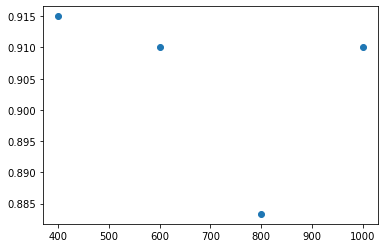

In [52]:
x = [400, 600, 800, 1000]
plt.scatter(x, np.array(acc_list)[:,0] )
plt.show()


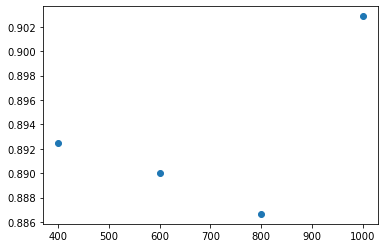

In [54]:
plt.scatter(x, np.array(acc_list)[:,1] )
plt.show()

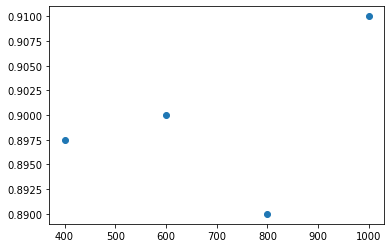

In [55]:
plt.scatter(x, np.array(acc_list)[:,2] )
plt.show()

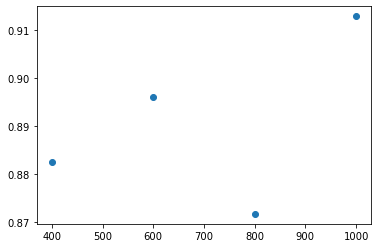

In [56]:
plt.scatter(x, np.array(acc_list)[:,3] )
plt.show()

# 8. Bonus

In [58]:
i = 0
s = 1
x = 1
d = [0] * 400
y = [0] * 400
while i < 400:
  image = PIL.Image.open("dataset/s" + str(s) + "/" + str(x) + ".pgm")
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  d[i] = image_array
  y[i] = s
  i = i + 1
  x = x + 1
  if x == 11:
    s = s + 1
    x = 1

In [59]:
trainingset_ratio = 0.7

b_training_data = [0] * int(len(d) * trainingset_ratio) 
b_testing_data = [0] * (len(d) - len(b_training_data))
b_training_labels = [0] * len(b_training_data)
b_testing_labels = [0] * len(b_testing_data)
curr_index = 0
for i in range(int(len(d) / 10)):
    for j in range(int(10 * trainingset_ratio)):
        b_training_data[i * int(10 * trainingset_ratio) + j] = d[i * 10 + j]
        b_training_labels[i * int(10 * trainingset_ratio) + j] = y[i * 10 + j]
        
    for j in range(int(10 * (1 - trainingset_ratio))):
        b_testing_data[i * int(10 * (1 - trainingset_ratio)) + j] = d[i * 10 + int(10 * trainingset_ratio) + j]
        b_testing_labels[i * int(10 * (1 - trainingset_ratio)) + j] = y[i * 10 + int(10 * trainingset_ratio) + j]


b_training_data = np.array(b_training_data)
b_training_labels = np.array(b_training_labels)
b_testing_data = np.array(b_testing_data)
b_testing_labels = np.array(b_testing_labels)

In [60]:
training_reduced_basis = calculate_reduced_basis(b_testing_data, alpha)

In [61]:
classify_images(alpha, training_reduced_basis, b_training_data, b_training_labels, b_testing_data, b_testing_labels)

When alpha = 0.8
K-NN classifier PCA 1  Accuracy is: 0.9583333333333334
K-NN classifier PCA 3  Accuracy is: 0.9166666666666666
K-NN classifier PCA 5  Accuracy is: 0.8916666666666667
K-NN classifier PCA 7  Accuracy is: 0.8333333333333334
**********************
When alpha = 0.85
K-NN classifier PCA 1  Accuracy is: 0.9583333333333334
K-NN classifier PCA 3  Accuracy is: 0.9416666666666667
K-NN classifier PCA 5  Accuracy is: 0.9
K-NN classifier PCA 7  Accuracy is: 0.8833333333333333
**********************
When alpha = 0.9
K-NN classifier PCA 1  Accuracy is: 0.9583333333333334
K-NN classifier PCA 3  Accuracy is: 0.9416666666666667
K-NN classifier PCA 5  Accuracy is: 0.9083333333333333
K-NN classifier PCA 7  Accuracy is: 0.8666666666666667
**********************
When alpha = 0.95
K-NN classifier PCA 1  Accuracy is: 0.9666666666666667
K-NN classifier PCA 3  Accuracy is: 0.9416666666666667
K-NN classifier PCA 5  Accuracy is: 0.9083333333333333
K-NN classifier PCA 7  Accuracy is: 0.8666666666666

In [62]:
b_pj_mat = lda(b_training_data, 5, 39, 40, 10304)

In [63]:
b_new_train = np.dot(b_training_data, b_pj_mat.T)
b_new_test = np.dot(b_testing_data, b_pj_mat.T)

In [64]:
model_1_lda.fit(b_new_train, b_training_labels)
model_3_lda.fit(b_new_train, b_training_labels)
model_5_lda.fit(b_new_train, b_training_labels)
model_7_lda.fit(b_new_train, b_training_labels)

KNeighborsClassifier(n_neighbors=7)

In [65]:
b_pred_model_1_lda = model_1_lda.predict(b_new_test)
b_pred_model_3_lda = model_3_lda.predict(b_new_test)
b_pred_model_5_lda = model_5_lda.predict(b_new_test)
b_pred_model_7_lda = model_7_lda.predict(b_new_test)

In [66]:
b_acc_1_lda = accuracy_score(b_testing_labels, b_pred_model_1_lda)
b_acc_3_lda = accuracy_score(b_testing_labels, b_pred_model_3_lda)
b_acc_5_lda = accuracy_score(b_testing_labels, b_pred_model_5_lda)
b_acc_7_lda = accuracy_score(b_testing_labels, b_pred_model_7_lda)
print(b_acc_1_lda)
print(b_acc_3_lda)
print(b_acc_5_lda)
print(b_acc_7_lda)

0.95
0.8916666666666667
0.875
0.7666666666666667


Compare PCA & LDA

In [67]:
print("K-NN classifier 1 LDA   Accuracy is: " + str(b_acc_1_lda))
print("K-NN classifier 3 LDA   Accuracy is: " + str(b_acc_3_lda))
print("K-NN classifier 5 LDA   Accuracy is: " + str(b_acc_5_lda))
print("K-NN classifier 7 LDA   Accuracy is: " + str(b_acc_7_lda))
classify_images(alpha, training_reduced_basis, b_training_data, b_training_labels, b_testing_data, b_testing_labels)

K-NN classifier 1 LDA   Accuracy is: 0.95
K-NN classifier 3 LDA   Accuracy is: 0.8916666666666667
K-NN classifier 5 LDA   Accuracy is: 0.875
K-NN classifier 7 LDA   Accuracy is: 0.7666666666666667
When alpha = 0.8
K-NN classifier PCA 1  Accuracy is: 0.9583333333333334
K-NN classifier PCA 3  Accuracy is: 0.9166666666666666
K-NN classifier PCA 5  Accuracy is: 0.8916666666666667
K-NN classifier PCA 7  Accuracy is: 0.8333333333333334
**********************
When alpha = 0.85
K-NN classifier PCA 1  Accuracy is: 0.9583333333333334
K-NN classifier PCA 3  Accuracy is: 0.9416666666666667
K-NN classifier PCA 5  Accuracy is: 0.9
K-NN classifier PCA 7  Accuracy is: 0.8833333333333333
**********************
When alpha = 0.9
K-NN classifier PCA 1  Accuracy is: 0.9583333333333334
K-NN classifier PCA 3  Accuracy is: 0.9416666666666667
K-NN classifier PCA 5  Accuracy is: 0.9083333333333333
K-NN classifier PCA 7  Accuracy is: 0.8666666666666667
**********************
When alpha = 0.95
K-NN classifier PCA